# Forex testing with the backtesting library and other experiments

In [36]:
#from bs4 import BeautifulSoup
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

## Import forex from spreadsheet and convert timestamp strings to an index

In [3]:
forexData = pd.read_csv("forexData.csv")
#forexJson = forexData.json()
price = pd.DataFrame(forexData)
#datetime.strptime(dt_string, "%Y.%m.%d %H:%M")
price["Date"] = price["Date"].apply(lambda x: datetime.strptime(x, "%Y.%m.%d %H:%M"))
price['Date']=price["Date"].apply(lambda x: pd.Timestamp(x, unit='s'))
price['Date']=pd.DatetimeIndex(price["Date"])

price = price.set_index('Date')
price

,Open,High,Low,Close,Volume,NotSure
Date,,,,,,
2020-01-27 01:05:00,1.10274,1.10313,1.10272,1.10302,264,0
2020-01-27 01:10:00,1.10302,1.10308,1.10275,1.10296,219,0
2020-01-27 01:15:00,1.10296,1.10329,1.10296,1.10322,401,0
2020-01-27 01:20:00,1.10322,1.10327,1.10310,1.10317,322,0
2020-01-27 01:25:00,1.10318,1.10340,1.10318,1.10338,359,0
...,...,...,...,...,...,...
2021-05-28 23:35:00,1.21915,1.21926,1.21915,1.21917,73,0
2021-05-28 23:40:00,1.21916,1.21939,1.21905,1.21936,140,0
2021-05-28 23:45:00,1.21936,1.21940,1.21917,1.21921,135,0


## testing with backtesting.py

In [ ]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA
from statistics import mean

def mySMA(myArr, period):
    return pd.Series(myArr).rolling(period).mean()
            
def myEMA(myArr, period):
    return pd.Series(myArr).ewm(adjust=False, span=period).mean()
    
def myMacd(myArr):
    twelve = myEMA(myArr, 12) 
    twentySix = myEMA(myArr, 26)
    macd = twelve-twentySix
#     print(macd, twelve, twentySix)
    return macd

def myMacdSignal(myArr):
    return myEMA(myMacd(myArr), 9)

def myMacdHist(myArr):
    return myMacd(myArr) - myMacdSignal(myArr)

class SmaCross(Strategy):
    
    def init(self):
        profitLossAmnt = 0
        closePrice = self.data.Close
        openPrice = self.data.Open
        #print("buy and hold range", tempprice[0], tempprice[-1])
        self.emaOpen4 = self.I(myEMA, openPrice, 4)
        self.emaOpen12 = self.I(myEMA, openPrice, 12)
        self.emaClose4 = self.I(myEMA, closePrice, 4)
        self.emaClose12 = self.I(myEMA, closePrice, 12)
#         self.ma3 = self.I(myEMA, tempprice, 100)

        #self.macd = self.I(myMacd, tempprice)
        #self.macdSignal = self.I(myMacdSignal, tempprice)
        #self.macdHist = self.I(myMacdHist, tempprice)

        
    def next(self):
        if crossover(self.emaOpen4, self.emaClose4):
            self.buy()
        elif crossover(self.emaClose4, self.emaOpen4):
            self.sell()

bt = Backtest(price, SmaCross,
              exclusive_orders=True)
stats = bt.run()
print(stats._trades["PnL"].sum())
print(stats._trades)
stats._trades.to_csv("trades.csv")

bt.plot()

# grouping data by when a run starts

In [63]:
maLength = 20
maOpenValues = myEMA(price["Open"], maLength)
maCloseValues = myEMA(price["Close"], maLength)
df = pd.DataFrame(columns=["hour", "runLengthCount"])
counter = 1
for i in range(1,len(price)):
    closeOverBefore = 1 if (maOpenValues[i-1] <= maCloseValues[i-1]) else 0
    closeOver = 1 if (maOpenValues[i] <= maCloseValues[i]) else 0
#     print(i, price.index[i], price.index[i].hour, price["Close"][i], maOpenValues[i], maCloseValues[i], closeOver)
    if(closeOverBefore != closeOver):
        if(counter > 50):
            df = df.append({"hour":price.index[i].hour, "runLengthCount":counter}, ignore_index=True)
        counter = 1
    else:
        counter = counter + 1
groupedDf = df.groupby(['hour']).count()
groupedDfSum = df.groupby("hour").sum()
groupedDf["sum"] = groupedDfSum["runLengthCount"]
groupedDf["average"] = groupedDf["sum"]/groupedDf["runLengthCount"]
print(groupedDf)
df.to_csv("run.csv")


      runLengthCount  sum    average
hour                                
0                 10  699  69.900000
1                  7  469  67.000000
2                  3  199  66.333333
3                  4  256  64.000000
4                  2  120  60.000000
5                  2  122  61.000000
6                  4  243  60.750000
7                  2  109  54.500000
8                  8  499  62.375000
9                  6  366  61.000000
10                 1   54  54.000000
12                 3  179  59.666667
13                10  537  53.700000
14                11  684  62.181818
15                 7  472  67.428571
16                 1   59  59.000000
17                 2  105  52.500000
18                 4  230  57.500000
19                 4  261  65.250000
20                 5  268  53.600000
21                10  613  61.300000
22                10  631  63.100000
23                 4  285  71.250000


## Plot results

5.217391304347826


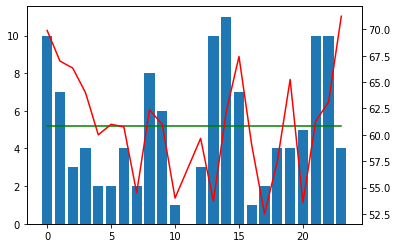

In [66]:
print(groupedDf.runLengthCount.mean())
fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax2 = ax.twinx()
ax.bar(groupedDf.index, groupedDf.runLengthCount)  # Plot some data on the axes.
x = np.linspace(groupedDf.runLengthCount.mean(), groupedDf.runLengthCount.mean(), len(groupedDf))
ax.plot(groupedDf.index,x, color="green")
ax2.plot(groupedDf.index,groupedDf.average, color="red")
z